## 1  Load Data

In [1]:
import pandas as pd
from datetime import datetime
# Paths to your files
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

# First attempt with folder ID
path1_10_present = 'foia-504-fy2010-present-asof-240930.csv'
path1_91_09 = 'foia-504-fy1991-fy2009-asof-240930.csv'

# Second attempt with folder name
path2_10_present = '/content/drive/My Drive/MS&E246/10_present.csv'
path2_91_09 = '/content/drive/My Drive/MS&E246/91_09.csv'

# Try reading with both paths
try:
    # Try first path
    df_10_present = pd.read_csv(path1_10_present)
    df_91_09 = pd.read_csv(path1_91_09)
    print("Successfully read from folder ID path")
except:
    try:
        # Try second path
        df_10_present = pd.read_csv(path2_10_present)
        df_91_09 = pd.read_csv(path2_91_09)
        print("Successfully read from folder name path")
    except Exception as e:
        print(f"Error: {e}")

C:\Users\caixu\AppData\Local\Temp\ipykernel_22872\1592800229.py:18: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_10_present = pd.read_csv(path1_10_present)


Successfully read from folder ID path


C:\Users\caixu\AppData\Local\Temp\ipykernel_22872\1592800229.py:19: DtypeWarning: Columns (12,13,14,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_91_09 = pd.read_csv(path1_91_09)


In [2]:
#What is the id of the dataset
id_columns = ['AsOfDate', 'Program', 'BorrName', 'BorrStreet', 'BorrCity', 'BorrState', 'BorrZip']

# Check for 10_present dataset
duplicates_10 = df_10_present.groupby(id_columns).size().reset_index(name='count')
has_duplicates_10 = any(duplicates_10['count'] > 1)

# Check for 91_09 dataset
duplicates_91 = df_91_09.groupby(id_columns).size().reset_index(name='count')
has_duplicates_91 = any(duplicates_91['count'] > 1)

print("Duplicates in 10_present:", has_duplicates_10)
print("Duplicates in 91_09:", has_duplicates_91)

# If there are duplicates, let's see some examples
if has_duplicates_10:
    print("\nExample duplicates in 10_present:")
    print(duplicates_10[duplicates_10['count'] > 1].head())

if has_duplicates_91:
    print("\nExample duplicates in 91_09:")
    print(duplicates_91[duplicates_91['count'] > 1].head())

Duplicates in 10_present: True
Duplicates in 91_09: True

Example duplicates in 10_present:
      AsOfDate  Program                   BorrName                BorrStreet  \
80   9/30/2024      504       1013 Enterprises LLC      1013 Lincoln Highway   
150  9/30/2024      504  10820 Hemlock Avenue, LLC      10820 Hemlock Avenue   
195  9/30/2024      504    1128 Petro Parkway, LLC    1128 Petroleum Parkway   
308  9/30/2024      504           123 Western, LLC  123 North Western Avenue   
528  9/30/2024      504                  1508, LLC  1508 Kaliste Saloom Road   

         BorrCity BorrState  BorrZip  count  
80   Schererville        IN    46375      2  
150       Fontana        CA    92337      2  
195     Broussard        LA    70518      2  
308       Chicago        IL    60612      2  
528     Lafayette        LA    70508      2  

Example duplicates in 91_09:
      AsOfDate  Program                        BorrName  \
236  9/30/2024      504               220PROPERTIES LLC   
248

## 2  Preliminary Cleaning

In [3]:
df_all = pd.concat([df_91_09, df_10_present])

In [4]:
def preliminary_clean_loan_data(df):
    # Make a copy to avoid modifying original data
    df_clean = df.copy()

    print("Initial size:", len(df_clean))

    # 1. Clean Loan Status
    if 'Status' in df_clean.columns:
        status_col = 'Status'
    elif 'LoanStatus' in df_clean.columns:
        status_col = 'LoanStatus'

    # Print unique statuses before cleaning
    print("\nUnique loan statuses before cleaning:")
    print(df_clean[status_col].value_counts())

    # Remove canceled and not funded loans but keep CHGOFF with zero charge-off
    canceled_mask = df_clean[status_col].str.contains('CANCLD|CANCEL|Canceled|NOT FUNDED', na=False, case=False)
    df_clean = df_clean[~canceled_mask]

    # 2. Check monetary values
    monetary_cols = ['GrossApproval', 'ThirdPartyDollars', 'GrossChargeOffAmount']
    for col in monetary_cols:
        if col in df_clean.columns:
            # Remove negative values
            df_clean = df_clean[df_clean[col].fillna(0) >= 0]

    # 3. Check dates
    date_cols = ['AsOfDate', 'ApprovalDate', 'PaidInFullDate']

    for col in date_cols:
        if col in df_clean.columns:
            # Convert to datetime
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

            # Remove future dates (except AsOfDate which might be a reporting date)
            if col != 'AsOfDate':
                df_clean = df_clean[
                    (df_clean[col].isna()) |
                    (df_clean[col] <= pd.Timestamp.now())
                ]

    # 4. Check logical consistency
    # PaidInFullDate should be after ApprovalDate
    if 'PaidInFullDate' in df_clean.columns and 'ApprovalDate' in df_clean.columns:
        df_clean = df_clean[
            ~((df_clean['PaidInFullDate'].notna()) &
              (df_clean['PaidInFullDate'] < df_clean['ApprovalDate']))
        ]

    # 5. Remove rows with missing crucial information
    crucial_cols = ['BorrName', 'GrossApproval', status_col]
    df_clean = df_clean.dropna(subset=crucial_cols)

    print("\nFinal size after cleaning:", len(df_clean))
    print("\nUnique loan statuses after cleaning:")
    print(df_clean[status_col].value_counts())

    return df_clean

# Clean both datasets
df_clean = preliminary_clean_loan_data(df_all)

Initial size: 218095

Unique loan statuses before cleaning:
LoanStatus
PIF           107245
EXEMPT         59555
CANCLD         30641
CHGOFF         12078
NOT FUNDED      8226
Name: count, dtype: int64

Final size after cleaning: 178877

Unique loan statuses after cleaning:
LoanStatus
PIF       107244
EXEMPT     59555
CHGOFF     12078
Name: count, dtype: int64


## 3  Train/Test Split

In [5]:
CUTOFF = "2016-01-01"

### 3.1 Process loans with approval date before CUTOFF as training set:

In [6]:
## 3.1.1 Loans that have approval date before CUTOFF and are in EXEMPT state

df_before_and_exempt = df_clean[(df_clean["ApprovalDate"] < CUTOFF) & (df_clean["LoanStatus"] == "EXEMPT")]
# Not default
df_before_and_exempt["Default"] = False
# Survival time is (CUTOFF - approval date)
df_before_and_exempt["SurvivalDays"] = (datetime.strptime(CUTOFF, '%Y-%m-%d') - df_before_and_exempt["ApprovalDate"]).dt.days
# Loss at default is 0
df_before_and_exempt["LossAtDefault"] = 0

In [7]:
## 3.1.2 Loans that have approval date before CUTOFF and are in PIF state

# 3.1.2(a) PaidInFullDate before CUTOFF: treat as paid at maturity
df_before_and_pif_1 = df_clean[(df_clean["ApprovalDate"] < CUTOFF) & (df_clean["LoanStatus"] == "PIF") & (df_clean["PaidInFullDate"] <= CUTOFF)]
# Not default
df_before_and_pif_1["Default"] = False
# Survival time is the term
df_before_and_pif_1["SurvivalDays"] = df_before_and_pif_1["TermInMonths"] * 30
# Loss at default is 0
df_before_and_pif_1["LossAtDefault"] = 0

# 3.1.2(b) PaidInFullDate after CUTOFF: treat as EXEMPT
df_before_and_pif_2 = df_clean[(df_clean["ApprovalDate"] < CUTOFF) & (df_clean["LoanStatus"] == "PIF") & (df_clean["PaidInFullDate"] > CUTOFF)]
# Not default
df_before_and_pif_2["Default"] = False
# Survival time is (CUTOFF - approval date)
df_before_and_pif_2["SurvivalDays"] = (datetime.strptime(CUTOFF, '%Y-%m-%d') - df_before_and_pif_2["ApprovalDate"]).dt.days
# Loss at default is 0
df_before_and_pif_2["LossAtDefault"] = 0

In [8]:
## 3.1.3 Loans that have approval date before CUTOFF and are in CHGOFF state

df_before_and_chgoff = df_clean[(df_clean["ApprovalDate"] < CUTOFF) & (df_clean["LoanStatus"] == "CHGOFF")]
df_before_and_chgoff["ChargeOffDate"] = df_before_and_chgoff["ChargeOffDate"].apply(pd.to_timedelta,unit = 'D') + datetime.strptime("1900-01-01", '%Y-%m-%d')
# Default is true
df_before_and_chgoff["Default"] = True
# Survival time is (charge off date - approval date)
df_before_and_chgoff["SurvivalDays"] = (df_before_and_chgoff["ChargeOffDate"] - df_before_and_chgoff["ApprovalDate"]).dt.days
# Loss at default is gross charge off amount
df_before_and_chgoff["LossAtDefault"] = df_before_and_chgoff["GrossChargeOffAmount"]

In [9]:
df_train = pd.concat([df_before_and_exempt, df_before_and_pif_1, df_before_and_pif_2, df_before_and_chgoff])
print("Size of training set:", len(df_train))

Size of training set: 132540


C:\Users\caixu\AppData\Local\Temp\ipykernel_22872\3210809056.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_train = pd.concat([df_before_and_exempt, df_before_and_pif_1, df_before_and_pif_2, df_before_and_chgoff])


### 3.2 Process loans with approval date after CUTOFF as testing set:

In [10]:
## 3.2.1 Loans that have approval date after CUTOFF and are in EXEMPT state

df_after_and_exempt = df_clean[(df_clean["ApprovalDate"] >= CUTOFF) & (df_clean["LoanStatus"] == "EXEMPT")]
# Not default
df_after_and_exempt["Default"] = False
# Survival time is (as of date - approval date)
df_after_and_exempt["SurvivalDays"] = (df_after_and_exempt["AsOfDate"] - df_after_and_exempt["ApprovalDate"]).dt.days
# Loss at default is 0
df_after_and_exempt["LossAtDefault"] = 0

In [11]:
## 3.2.2 Loans that have approval date after CUTOFF and are in PIF state: all treat as paid at maturity
df_after_and_pif = df_clean[(df_clean["ApprovalDate"] >= CUTOFF) & (df_clean["LoanStatus"] == "PIF")]
# Not default
df_after_and_pif["Default"] = False
# Survival time is the term
df_after_and_pif["SurvivalDays"] = df_after_and_pif["TermInMonths"] * 30
# Loss at default is 0
df_after_and_pif["LossAtDefault"] = 0

In [12]:
## 3.2.3 Loans that have approval date after CUTOFF and are in CHGOFF state

df_after_and_chgoff = df_clean[(df_clean["ApprovalDate"] >= CUTOFF) & (df_clean["LoanStatus"] == "CHGOFF")]
df_after_and_chgoff["ChargeOffDate"] = df_after_and_chgoff["ChargeOffDate"].apply(pd.to_timedelta,unit = 'D') + datetime.strptime("1900-01-01", '%Y-%m-%d')
# Default is true
df_after_and_chgoff["Default"] = True
# Survival time is (charge off date - approval date)
df_after_and_chgoff["SurvivalDays"] = (df_after_and_chgoff["ChargeOffDate"] - df_after_and_chgoff["ApprovalDate"]).dt.days
# Loss at default is gross charge off amount
df_after_and_chgoff["LossAtDefault"] = df_after_and_chgoff["GrossChargeOffAmount"]

In [13]:
df_test = pd.concat([df_after_and_exempt, df_after_and_pif, df_after_and_chgoff])
print("Size of testing set:", len(df_test))

Size of testing set: 46337


C:\Users\caixu\AppData\Local\Temp\ipykernel_22872\2429493966.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_after_and_exempt, df_after_and_pif, df_after_and_chgoff])


## 4  Data Exploration: Test of Feature Relevance

In [14]:
df_train["NaicsCodeBigCategory"] = df_train["NaicsCode"].apply(lambda x: str(x)[:2])
df_train["JS20"] = df_train["JobsSupported"]>20

In [15]:
from scipy.stats import chi2_contingency

candidates = ["BorrState", "DeliveryMethod", "Subprogram", "NaicsCodeBigCategory", "ProjectState", "BusinessType", "JS20"]
chi2s = []
pvalues = []

for col in candidates:
    df_train_not_na = df_train[~df_train[col].isna()]
    cross_tab = pd.crosstab(df_train_not_na[col], df_train_not_na["Default"])
    chi2_results = chi2_contingency(cross_tab)
    chi2s.append(float(chi2_results.statistic))
    pvalues.append(float(chi2_results.pvalue))

candidates.append("ThirdPartyLender_Name_FirstLetterUpper")
df_train_not_na = df_train[~df_train["ThirdPartyLender_Name"].isna()]
cross_tab = pd.crosstab(df_train_not_na["ThirdPartyLender_Name"].apply(lambda x:x[0].isupper()), df_train_not_na["Default"])
chi2_results = chi2_contingency(cross_tab)
chi2s.append(float(chi2_results.statistic))
pvalues.append(float(chi2_results.pvalue))

result = pd.DataFrame({"Candidate Feature":candidates, "Chi2":chi2s, "p-value":pvalues}).sort_values(by='p-value')
result

,Candidate Feature,Chi2,p-value
3,NaicsCodeBigCategory,2485.698730,0.000000e+00
0,BorrState,1639.732772,2.262880e-308
4,ProjectState,1621.465405,8.761926e-304
1,DeliveryMethod,384.455856,6.346604e-82
2,Subprogram,322.226754,1.537135e-69
6,JS20,40.343651,2.129965e-10
5,BusinessType,20.471881,3.585812e-05
7,ThirdPartyLender_Name_FirstLetterUpper,1.996780,1.576338e-01


## 5  Kaplan Meier Curve of Overall Survival

In [16]:
from lifelines import KaplanMeierFitter

Text(0.5, 1.0, 'Overall Survival')

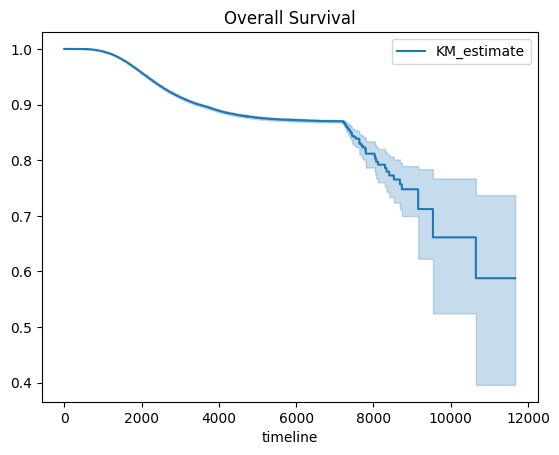

In [23]:
kmf = KaplanMeierFitter()
kmf.fit(durations = df_train["SurvivalDays"], event_observed = df_train["Default"])
kmf.plot_survival_function()
plt.title("Overall Survival")

Text(0.5, 1.0, 'Survival of different Naics Big Category group')

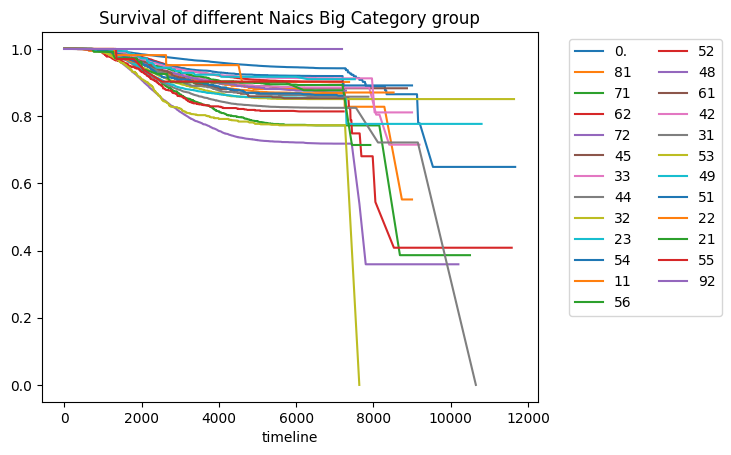

In [28]:
import matplotlib.pyplot as plt

naics_big_cat = df_train["NaicsCode"].apply(lambda x: str(x)[:2])
cat_list = list(naics_big_cat.unique())

ax = plt.subplot(111)
for c in cat_list:
    m = (naics_big_cat == c)
    kmf.fit(durations = df_train["SurvivalDays"][m], event_observed = df_train["Default"][m], label = c)
    kmf.survival_function_.plot(ax = ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.title("Survival of different Naics Big Category group")

Text(0.5, 1.0, 'Survival of different Borrower State group')

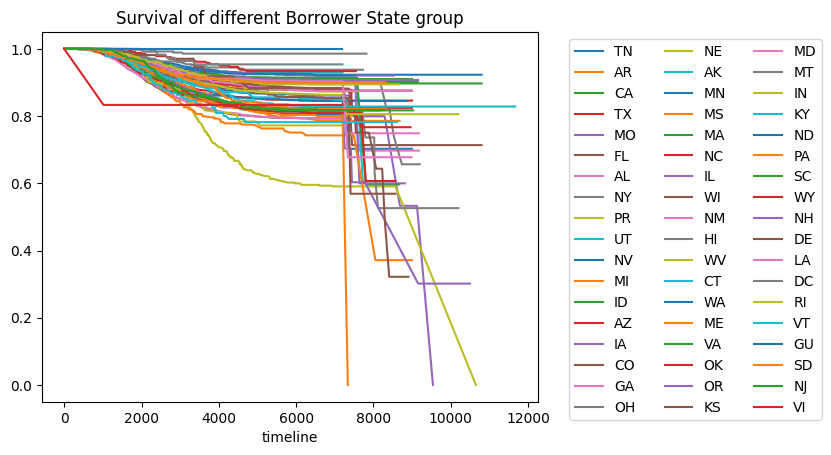

In [30]:
cat_list = list(df_train["BorrState"].unique())

ax = plt.subplot(111)
for c in cat_list:
    m = (df_train["BorrState"] == c)
    kmf.fit(durations = df_train["SurvivalDays"][m], event_observed = df_train["Default"][m], label = c)
    kmf.survival_function_.plot(ax = ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)
plt.title("Survival of different Borrower State group")

Text(0.5, 1.0, 'Survival of different Project State group')

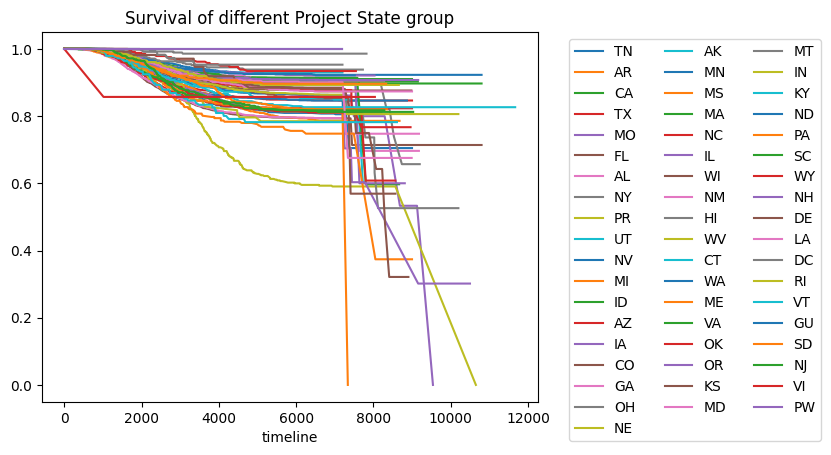

In [45]:
cat_list = list(df_train["ProjectState"][~df_train["ProjectState"].isna()].unique())

ax = plt.subplot(111)
for c in cat_list:
    m = (df_train["ProjectState"] == c)
    kmf.fit(durations = df_train["SurvivalDays"][m], event_observed = df_train["Default"][m], label = c)
    kmf.survival_function_.plot(ax = ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)
plt.title("Survival of different Project State group")